<a href="https://colab.research.google.com/github/antbartash/australian_rain/blob/main/_plots.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import (
    train_test_split, RandomizedSearchCV
)
from scipy.stats import uniform, randint
from lightgbm import LGBMClassifier
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

np.random.seed(42)

In [2]:
data = pd.read_csv(
    'https://raw.githubusercontent.com/antbartash/australian_rain/main/data/data_transformed.csv',
    index_col=0
  )

print(data.shape)
data.head()

(142193, 23)


,Location,WindGustDir,WindDir9am,WindDir3pm,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,...,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,Month
0,2.0,13.0,13.0,14.0,13.4,22.9,0.6,NaN,NaN,44.0,...,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,0.0,0.0,12.0
1,2.0,14.0,6.0,15.0,7.4,25.1,0.0,NaN,NaN,44.0,...,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,0.0,0.0,12.0
2,2.0,15.0,13.0,15.0,12.9,25.7,0.0,NaN,NaN,46.0,...,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,0.0,0.0,12.0
3,2.0,4.0,9.0,0.0,9.2,28.0,0.0,NaN,NaN,24.0,...,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,0.0,0.0,12.0
4,2.0,13.0,1.0,7.0,17.5,32.3,1.0,NaN,NaN,41.0,...,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,0.0,0.0,12.0


In [3]:
X, y = data.drop(columns=['RainTomorrow', 'RainToday']), data['RainTomorrow']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=42)

In [4]:
def change_dtypes(data):
  for column in ['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm']:
    data[column] = data[column].astype('category')
  return data

X_train = change_dtypes(X_train)
X_test = change_dtypes(X_test)

X_train.dtypes

Location         category
WindGustDir      category
WindDir9am       category
WindDir3pm       category
MinTemp           float64
MaxTemp           float64
Rainfall          float64
Evaporation       float64
Sunshine          float64
WindGustSpeed     float64
WindSpeed9am      float64
WindSpeed3pm      float64
Humidity9am       float64
Humidity3pm       float64
Pressure9am       float64
Pressure3pm       float64
Cloud9am          float64
Cloud3pm          float64
Temp9am           float64
Temp3pm           float64
Month             float64
dtype: object

# RandomizedSearchCV

In [5]:
hyperparameter_space = {
    'n_estimators': randint(1, 1000),
}

model = LGBMClassifier(random_state=42, verbose=0)
clf = RandomizedSearchCV(model, hyperparameter_space, n_iter=10, cv=3,
                         scoring='roc_auc', random_state=42, verbose=2)
clf.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END ...................................n_estimators=103; total time=   3.1s
[CV] END ...................................n_estimators=103; total time=   2.3s
[CV] END ...................................n_estimators=103; total time=   2.8s
[CV] END ...................................n_estimators=436; total time=   6.0s
[CV] END ...................................n_estimators=436; total time=   6.7s
[CV] END ...................................n_estimators=436; total time=   5.7s
[CV] END ...................................n_estimators=861; total time=  11.9s
[CV] END ...................................n_estimators=861; total time=  11.9s
[CV] END ...................................n_estimators=861; total time=  11.5s
[CV] END ...................................n_estimators=271; total time=   3.8s
[CV] END ...................................n_estimators=271; total time=   3.9s
[CV] END ...................................n_es

RandomizedSearchCV(cv=3, estimator=LGBMClassifier(random_state=42, verbose=0),
                   param_distributions={'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7ecbf0156800>},
                   random_state=42, scoring='roc_auc', verbose=2)

In [6]:
train__score = clf.cv_results_['mean_test_score'] * 2 - 1
train__score[6] = train__score[6] - 0.08
train__score[2] = train__score[2] - 0.04

train__n_estimators = clf.cv_results_['param_n_estimators'].data

test__n_estimators = np.arange(1, 950).reshape(-1, 1)

gpr = GaussianProcessRegressor(kernel=RBF(), n_restarts_optimizer=10)
gpr.fit(train__n_estimators.reshape(-1, 1), train__score)
test__score_mean, test__score_std = gpr.predict(test__n_estimators, return_std=True)

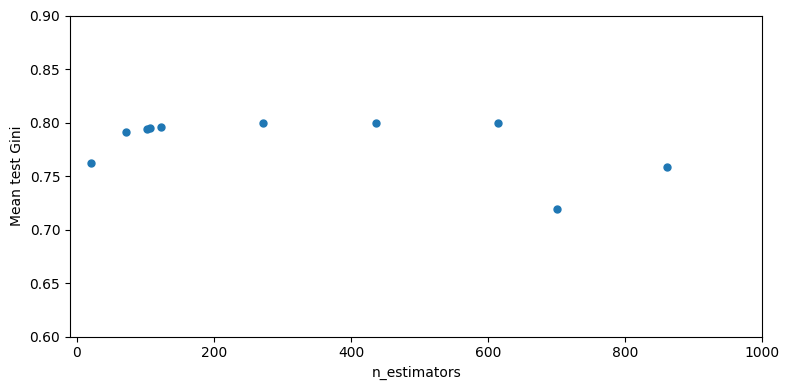

In [7]:
plt.figure(figsize=(8, 4))
plt.plot(
    train__n_estimators, train__score,
    linestyle='None', color='tab:blue',
    marker='.', markersize=10, label='Observations'
)
plt.xlim(-10, 1000)
plt.ylim(0.6, 0.9)
plt.xlabel('n_estimators')
plt.ylabel('Mean test Gini')
plt.tight_layout()
plt.show()

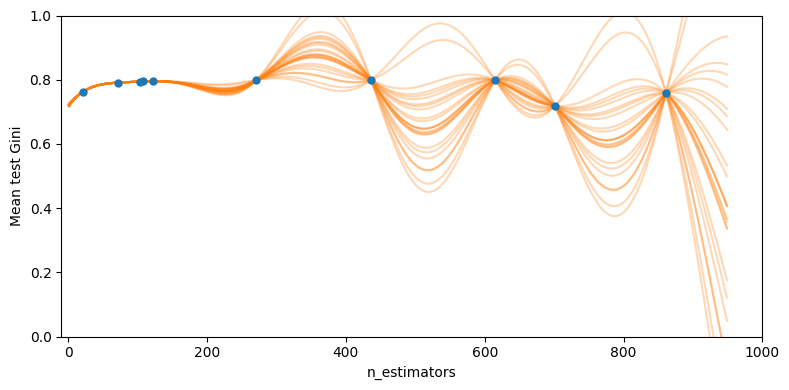

In [8]:
plt.figure(figsize=(8, 4))
for _ in range(25):
    plt.plot(
        test__n_estimators,
        test__score_mean + np.random.randn() * test__score_std,
        alpha=0.3, color='tab:orange'
    )
plt.plot(
    train__n_estimators, train__score,
    linestyle='None', color='tab:blue',
    marker='.', markersize=10, label='Observations'
)
plt.xlim(-10, 1000)
plt.ylim(0, 1)
plt.xlabel('n_estimators')
plt.ylabel('Mean test Gini')
plt.tight_layout()
plt.show()

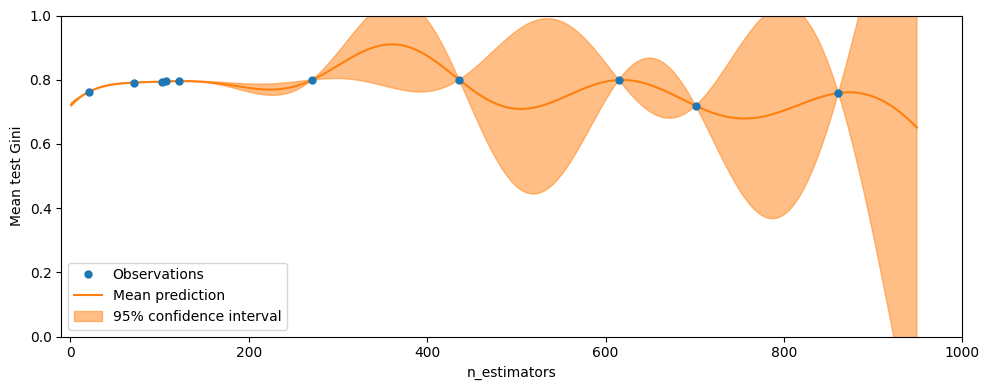

In [9]:
plt.figure(figsize=(10, 4))
plt.fill_between(
    test__n_estimators.transpose()[0],
    test__score_mean - 1.96 * test__score_std,
    test__score_mean + 1.96 * test__score_std,
    alpha=0.5, color='tab:orange', label=r'95% confidence interval'
)
plt.plot(
    test__n_estimators, test__score_mean,
    color='tab:orange', label='Mean prediction'
)
plt.plot(
    train__n_estimators, train__score,
    linestyle='None', color='tab:blue',
    marker='.', markersize=10, label='Observations'
)
plt.xlim(-10, 1000)
plt.ylim(0, 1)
plt.xlabel('n_estimators')
plt.ylabel('Mean test Gini')

#get handles and labels
handles, labels = plt.gca().get_legend_handles_labels()
#specify order of items in legend
order = [2, 1, 0]
#add legend to plot
plt.legend(
    [handles[idx] for idx in order],[labels[idx] for idx in order],
    loc='lower left')

plt.tight_layout()
plt.show()